# Imports

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Parameters

In [2]:
input_size = (256, 256, 3)
img_height, img_width = (256, 256)
n_classes = 1
batch_size = 32
epochs = 10

# Data Generator

In [3]:
data_dir = '../Data/train'
data_dir = pathlib.Path(data_dir)

## Preprocessed Data

Reading in the data using keras data generator. Read in rgb with a train-validation split of 0.2

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

Found 25181 files belonging to 2 classes.
Using 20145 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

Found 25181 files belonging to 2 classes.
Using 5036 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['normal', 'pneumonia']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
def preprocess_images(img, flag='default'):
    if flag == 'default':
        # Scale to (-1,1)
        img = tf.keras.applications.inception_v3.preprocess_input(img)
    elif flag == 'vgg':
        # convert the input images from RGB to BGR,
        #then will zero-center each color channel with respect to the ImageNet dataset,
        #without scaling.
        img = tf.keras.applications.vgg16.preprocess_input(img)
    elif flag == 'resnet':
        # convert the input images from RGB to BGR,
        #then will zero-center each color channel with respect to the ImageNet dataset,
        #without scaling.
        img = tf.keras.applications.resnet.preprocess_input(img)
    elif flag == 'nothing':
        # Do no processing
        return img
    return img

**Run the below cell if the preprocessing required is the default option from (-1, 1)
For InceptionV3, InceptionResnetV2**

In [9]:
train_ds = train_ds.map(lambda x, y: (preprocess_images(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_images(x), y))

**Run the below cell if the preprocessing required is for VGG network**

In [10]:
# VGG-16
train_ds = train_ds.map(lambda x, y: (preprocess_images(x, 'vgg'), y))
val_ds = val_ds.map(lambda x, y: (preprocess_images(x, 'vgg'), y))

**Run the below cell if the preprocessing required is for Resnet network**

In [9]:
# RESNET
train_ds = train_ds.map(lambda x, y: (preprocess_images(x, 'res'), y))
val_ds = val_ds.map(lambda x, y: (preprocess_images(x, 'res'), y))

## Unprocessed Data

**Run this part if no preprocessing is needed, for networks that contain the preprocessing in the input layers, like EfficientnetB3**

In [4]:
train_original_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

Found 25181 files belonging to 2 classes.
Using 20145 files for training.


In [5]:
val_original_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

Found 25181 files belonging to 2 classes.
Using 5036 files for validation.


In [6]:
class_names = train_original_ds.class_names
print(class_names)

['normal', 'pneumonia']


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_original_ds = train_original_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_original_ds = val_original_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Augmented Data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
#test_ds = prepare(test_ds)

# InceptionV3

In [32]:
# create the base pre-trained model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = input_size)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 2 classes
predictions = Dense(n_classes, activation='sigmoid')(x)

In [33]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [34]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
630/630 [==============================] - 43s 66ms/step - loss: 1.9340 - accuracy: 0.8333 - val_loss: 0.3153 - val_accuracy: 0.8900
Epoch 2/10
630/630 [==============================] - 41s 65ms/step - loss: 0.3561 - accuracy: 0.8744 - val_loss: 0.2723 - val_accuracy: 0.8946
Epoch 3/10
630/630 [==============================] - 41s 65ms/step - loss: 0.2983 - accuracy: 0.8842 - val_loss: 0.2711 - val_accuracy: 0.8946
Epoch 4/10
630/630 [==============================] - 41s 65ms/step - loss: 0.2793 - accuracy: 0.8893 - val_loss: 0.2664 - val_accuracy: 0.8969
Epoch 5/10
630/630 [==============================] - 41s 65ms/step - loss: 0.2815 - accuracy: 0.8906 - val_loss: 0.2792 - val_accuracy: 0.8898
Epoch 6/10
630/630 [==============================] - 41s 65ms/step - loss: 0.2732 - accuracy: 0.8959 - val_loss: 0.2684 - val_accuracy: 0.8952
Epoch 7/10
630/630 [==============================] - 41s 65ms/step - loss: 0.2722 - accuracy: 0.8934 - val_loss: 0.2884 - val_accuracy:

In [35]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)


0 input_3
1 conv2d_188
2 batch_normalization_188
3 activation_188
4 conv2d_189
5 batch_normalization_189
6 activation_189
7 conv2d_190
8 batch_normalization_190
9 activation_190
10 max_pooling2d_8
11 conv2d_191
12 batch_normalization_191
13 activation_191
14 conv2d_192
15 batch_normalization_192
16 activation_192
17 max_pooling2d_9
18 conv2d_196
19 batch_normalization_196
20 activation_196
21 conv2d_194
22 conv2d_197
23 batch_normalization_194
24 batch_normalization_197
25 activation_194
26 activation_197
27 average_pooling2d_18
28 conv2d_193
29 conv2d_195
30 conv2d_198
31 conv2d_199
32 batch_normalization_193
33 batch_normalization_195
34 batch_normalization_198
35 batch_normalization_199
36 activation_193
37 activation_195
38 activation_198
39 activation_199
40 mixed0
41 conv2d_203
42 batch_normalization_203
43 activation_203
44 conv2d_201
45 conv2d_204
46 batch_normalization_201
47 batch_normalization_204
48 activation_201
49 activation_204
50 average_pooling2d_19
51 conv2d_200
52 c

In [36]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [37]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [38]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
630/630 [==============================] - 52s 80ms/step - loss: 0.4567 - accuracy: 0.7938 - val_loss: 0.3374 - val_accuracy: 0.8687
Epoch 2/10
630/630 [==============================] - 50s 79ms/step - loss: 0.3075 - accuracy: 0.8796 - val_loss: 0.2803 - val_accuracy: 0.8856
Epoch 3/10
630/630 [==============================] - 49s 78ms/step - loss: 0.2677 - accuracy: 0.8941 - val_loss: 0.2559 - val_accuracy: 0.8952
Epoch 4/10
630/630 [==============================] - 49s 78ms/step - loss: 0.2414 - accuracy: 0.9065 - val_loss: 0.2404 - val_accuracy: 0.9039
Epoch 5/10
630/630 [==============================] - 49s 78ms/step - loss: 0.2190 - accuracy: 0.9172 - val_loss: 0.2291 - val_accuracy: 0.9083
Epoch 6/10
630/630 [==============================] - 49s 78ms/step - loss: 0.1977 - accuracy: 0.9259 - val_loss: 0.2257 - val_accuracy: 0.9144
Epoch 7/10
630/630 [==============================] - 49s 78ms/step - loss: 0.1770 - accuracy: 0.9354 - val_loss: 0.2155 - val_accuracy:

Sigmoid vs Softmax for Binary Classification: [LINK](https://stats.stackexchange.com/questions/233658/softmax-vs-sigmoid-function-in-logistic-classifier)

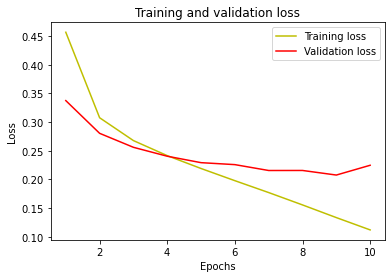

In [44]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

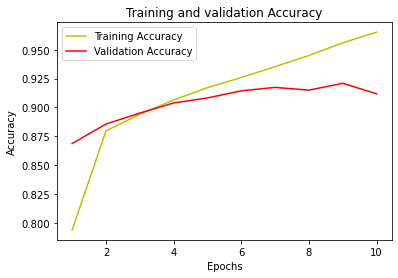

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## InceptionV3 input preprocessing

In [18]:
# create the base pre-trained model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = input_size)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(n_classes, activation='sigmoid')(x)

In [ ]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [75]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_940 (Conv2D)             (None, 127, 127, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_940 (BatchN (None, 127, 127, 32) 96          conv2d_940[0][0]                 
__________________________________________________________________________________________________
activation_940 (Activation)     (None, 127, 127, 32) 0           batch_normalization_940[0][0]    
____________________________________________________________________________________________

In [20]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
630/630 [==============================] - 46s 69ms/step - loss: 0.2935 - accuracy: 0.8882 - val_loss: 0.2262 - val_accuracy: 0.9130
Epoch 2/10
630/630 [==============================] - 43s 69ms/step - loss: 0.2236 - accuracy: 0.9143 - val_loss: 0.2096 - val_accuracy: 0.9210
Epoch 3/10
630/630 [==============================] - 44s 69ms/step - loss: 0.2206 - accuracy: 0.9163 - val_loss: 0.2039 - val_accuracy: 0.9232
Epoch 4/10
630/630 [==============================] - 43s 67ms/step - loss: 0.2008 - accuracy: 0.9243 - val_loss: 0.1986 - val_accuracy: 0.9251
Epoch 5/10
630/630 [==============================] - 43s 68ms/step - loss: 0.1908 - accuracy: 0.9289 - val_loss: 0.1979 - val_accuracy: 0.9228
Epoch 6/10
630/630 [==============================] - 43s 68ms/step - loss: 0.1824 - accuracy: 0.9320 - val_loss: 0.2024 - val_accuracy: 0.9259
Epoch 7/10
630/630 [==============================] - 44s 69ms/step - loss: 0.1781 - accuracy: 0.9346 - val_loss: 0.2116 - val_accuracy:

In [21]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)


0 input_2
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 conv2d

In [22]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [23]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
630/630 [==============================] - 55s 83ms/step - loss: 0.2277 - accuracy: 0.9151 - val_loss: 0.1963 - val_accuracy: 0.9263
Epoch 2/10
630/630 [==============================] - 51s 81ms/step - loss: 0.1316 - accuracy: 0.9563 - val_loss: 0.1848 - val_accuracy: 0.9313
Epoch 3/10
630/630 [==============================] - 51s 82ms/step - loss: 0.0904 - accuracy: 0.9740 - val_loss: 0.1813 - val_accuracy: 0.9357
Epoch 4/10
630/630 [==============================] - 52s 83ms/step - loss: 0.0607 - accuracy: 0.9854 - val_loss: 0.1818 - val_accuracy: 0.9375
Epoch 5/10
630/630 [==============================] - 52s 82ms/step - loss: 0.0392 - accuracy: 0.9922 - val_loss: 0.1858 - val_accuracy: 0.9373
Epoch 6/10
630/630 [==============================] - 52s 82ms/step - loss: 0.0252 - accuracy: 0.9962 - val_loss: 0.1916 - val_accuracy: 0.9394
Epoch 7/10
630/630 [==============================] - 51s 81ms/step - loss: 0.0164 - accuracy: 0.9985 - val_loss: 0.1988 - val_accuracy:

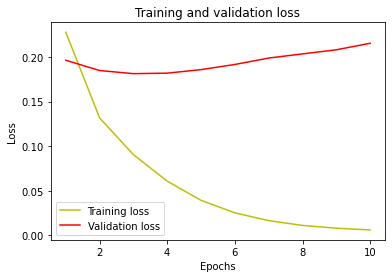

In [25]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

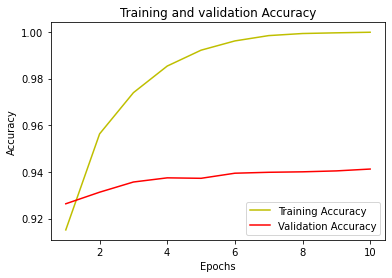

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## InceptionV3 Regularization

In [11]:
# create the base pre-trained model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = input_size)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(n_classes, activation='sigmoid')(x)

In [12]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [75]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_940 (Conv2D)             (None, 127, 127, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_940 (BatchN (None, 127, 127, 32) 96          conv2d_940[0][0]                 
__________________________________________________________________________________________________
activation_940 (Activation)     (None, 127, 127, 32) 0           batch_normalization_940[0][0]    
____________________________________________________________________________________________

In [13]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
630/630 [==============================] - 64s 74ms/step - loss: 0.2938 - accuracy: 0.8872 - val_loss: 0.2215 - val_accuracy: 0.9146
Epoch 2/10
630/630 [==============================] - 44s 70ms/step - loss: 0.2363 - accuracy: 0.9088 - val_loss: 0.2078 - val_accuracy: 0.9208
Epoch 3/10
630/630 [==============================] - 44s 70ms/step - loss: 0.2244 - accuracy: 0.9157 - val_loss: 0.2202 - val_accuracy: 0.9134
Epoch 4/10
630/630 [==============================] - 44s 70ms/step - loss: 0.2118 - accuracy: 0.9198 - val_loss: 0.2275 - val_accuracy: 0.9216
Epoch 5/10
630/630 [==============================] - 44s 70ms/step - loss: 0.2016 - accuracy: 0.9261 - val_loss: 0.2110 - val_accuracy: 0.9210
Epoch 6/10
630/630 [==============================] - 44s 70ms/step - loss: 0.1938 - accuracy: 0.9252 - val_loss: 0.1973 - val_accuracy: 0.9275
Epoch 7/10
630/630 [==============================] - 44s 70ms/step - loss: 0.1919 - accuracy: 0.9285 - val_loss: 0.1966 - val_accuracy:

In [21]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)


0 input_2
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed0
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 average_pooling2d_10
51 conv2d_106
52 conv2d_108
53 conv2d

In [14]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [15]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
630/630 [==============================] - 54s 83ms/step - loss: 0.2444 - accuracy: 0.9076 - val_loss: 0.1958 - val_accuracy: 0.9259
Epoch 2/10
630/630 [==============================] - 52s 82ms/step - loss: 0.1535 - accuracy: 0.9462 - val_loss: 0.1827 - val_accuracy: 0.9303
Epoch 3/10
630/630 [==============================] - 52s 82ms/step - loss: 0.1138 - accuracy: 0.9617 - val_loss: 0.1760 - val_accuracy: 0.9376
Epoch 4/10
630/630 [==============================] - 52s 82ms/step - loss: 0.0843 - accuracy: 0.9747 - val_loss: 0.1752 - val_accuracy: 0.9359
Epoch 5/10
630/630 [==============================] - 52s 83ms/step - loss: 0.0593 - accuracy: 0.9840 - val_loss: 0.1784 - val_accuracy: 0.9394
Epoch 6/10
630/630 [==============================] - 52s 82ms/step - loss: 0.0404 - accuracy: 0.9912 - val_loss: 0.1844 - val_accuracy: 0.9402
Epoch 7/10
630/630 [==============================] - 51s 82ms/step - loss: 0.0273 - accuracy: 0.9958 - val_loss: 0.1922 - val_accuracy:

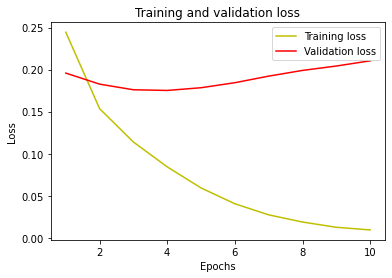

In [17]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

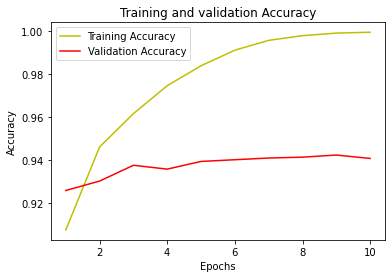

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# InceptionResNetV2

In [11]:
# create the base pre-trained model

base_model_inception_resnet_v2 = tf.keras.applications.InceptionResNetV2(weights='imagenet',
                                                     include_top=False, input_shape = input_size)

# add a global spatial average pooling layer
x = base_model_inception_resnet_v2.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(n_classes, activation='sigmoid')(x)

219070464/219055592 [==============================] - 22s 0us/step


In [12]:
# this is the model we will train
model_inception_resnet_v2 = Model(inputs=base_model_inception_resnet_v2.input, outputs=predictions)

In [13]:
model_inception_resnet_v2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception resnet v2. We will freeze the bottom N layers
# and train the remaining top layers.
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model_inception_resnet_v2.layers):
   print(i, layer.name)


0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed_5b
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 conv2d_12
51 conv2d_14
52 conv2d_17
53 batch_normalization_12
54 batch_normalization_14
55 batch_normalization_17
56 activa

In [15]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_inception_resnet_v2.layers[:698]:
   layer.trainable = False
for layer in model_inception_resnet_v2.layers[698:]:
   layer.trainable = True

In [16]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model_inception_resnet_v2.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [17]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model_inception_resnet_v2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
630/630 [==============================] - 137s 185ms/step - loss: 0.4723 - accuracy: 0.7573 - val_loss: 0.3623 - val_accuracy: 0.8465
Epoch 2/10
630/630 [==============================] - 115s 183ms/step - loss: 0.3053 - accuracy: 0.8797 - val_loss: 0.2595 - val_accuracy: 0.9011
Epoch 3/10
630/630 [==============================] - 115s 182ms/step - loss: 0.2192 - accuracy: 0.9169 - val_loss: 0.2202 - val_accuracy: 0.9172
Epoch 4/10
630/630 [==============================] - 114s 181ms/step - loss: 0.1720 - accuracy: 0.9365 - val_loss: 0.1992 - val_accuracy: 0.9259
Epoch 5/10
630/630 [==============================] - 114s 180ms/step - loss: 0.1348 - accuracy: 0.9526 - val_loss: 0.1945 - val_accuracy: 0.9315
Epoch 6/10
630/630 [==============================] - 114s 180ms/step - loss: 0.1026 - accuracy: 0.9656 - val_loss: 0.2035 - val_accuracy: 0.9313
Epoch 7/10
630/630 [==============================] - 114s 181ms/step - loss: 0.0743 - accuracy: 0.9761 - val_loss: 0.2023 -

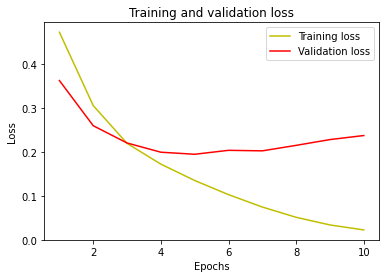

In [18]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

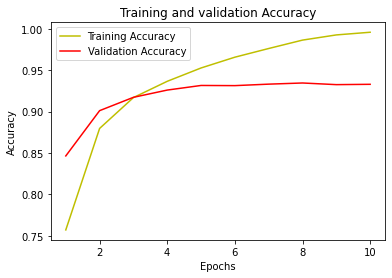

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# EfficientNetB3

## Train

In [8]:
# create the base pre-trained model

base_model_efficientnet_b3 = tf.keras.applications.EfficientNetB3(weights='imagenet',
                                                     include_top=False, input_shape = input_size)

# add a global spatial average pooling layer
x = base_model_efficientnet_b3.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(n_classes, activation='sigmoid')(x)

43950080/43941136 [==============================] - 4s 0us/step


In [9]:
# this is the model we will train
model_efficientnet_b3 = Model(inputs=base_model_efficientnet_b3.input, outputs=predictions)

In [75]:
model_efficientnet_b3.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_940 (Conv2D)             (None, 127, 127, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_940 (BatchN (None, 127, 127, 32) 96          conv2d_940[0][0]                 
__________________________________________________________________________________________________
activation_940 (Activation)     (None, 127, 127, 32) 0           batch_normalization_940[0][0]    
____________________________________________________________________________________________

In [11]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model_efficientnet_b3.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_efficientnet_b3.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model_efficientnet_b3.fit(
  train_original_ds,
  validation_data=val_original_ds,
  epochs=epochs
)


Epoch 1/10
630/630 [==============================] - 101s 129ms/step - loss: 0.2083 - accuracy: 0.9190 - val_loss: 0.1642 - val_accuracy: 0.9363
Epoch 2/10
630/630 [==============================] - 78s 124ms/step - loss: 0.1702 - accuracy: 0.9348 - val_loss: 0.1735 - val_accuracy: 0.9343
Epoch 3/10
630/630 [==============================] - 78s 123ms/step - loss: 0.1575 - accuracy: 0.9389 - val_loss: 0.1490 - val_accuracy: 0.9390
Epoch 4/10
630/630 [==============================] - 77s 123ms/step - loss: 0.1521 - accuracy: 0.9401 - val_loss: 0.1482 - val_accuracy: 0.9428
Epoch 5/10
630/630 [==============================] - 78s 123ms/step - loss: 0.1433 - accuracy: 0.9440 - val_loss: 0.1555 - val_accuracy: 0.9402
Epoch 6/10
630/630 [==============================] - 77s 123ms/step - loss: 0.1390 - accuracy: 0.9466 - val_loss: 0.1393 - val_accuracy: 0.9474
Epoch 7/10
630/630 [==============================] - 78s 123ms/step - loss: 0.1300 - accuracy: 0.9494 - val_loss: 0.1552 - val_a

In [12]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model_efficientnet_b3.layers):
   print(i, layer.name)


0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block1b_dwconv
18 block1b_bn
19 block1b_activation
20 block1b_se_squeeze
21 block1b_se_reshape
22 block1b_se_reduce
23 block1b_se_expand
24 block1b_se_excite
25 block1b_project_conv
26 block1b_project_bn
27 block1b_drop
28 block1b_add
29 block2a_expand_conv
30 block2a_expand_bn
31 block2a_expand_activation
32 block2a_dwconv_pad
33 block2a_dwconv
34 block2a_bn
35 block2a_activation
36 block2a_se_squeeze
37 block2a_se_reshape
38 block2a_se_reduce
39 block2a_se_expand
40 block2a_se_excite
41 block2a_project_conv
42 block2a_project_bn
43 block2b_expand_conv
44 block2b_expand_bn
45 block2b_expand_activation
46 block2b_dwconv
47 block2b_bn
48 block2b_activation
49 block2b_se_squeeze
50 block2b_se

In [13]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_efficientnet_b3.layers[:264]:
   layer.trainable = False
for layer in model_efficientnet_b3.layers[264:]:
   layer.trainable = True

In [14]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model_efficientnet_b3.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model_efficientnet_b3.fit(
  train_original_ds,
  validation_data=val_original_ds,
  epochs=epochs
)

Epoch 1/10
630/630 [==============================] - 111s 168ms/step - loss: 0.3146 - accuracy: 0.8929 - val_loss: 0.2076 - val_accuracy: 0.9261
Epoch 2/10
630/630 [==============================] - 105s 166ms/step - loss: 0.1865 - accuracy: 0.9265 - val_loss: 0.1781 - val_accuracy: 0.9355
Epoch 3/10
630/630 [==============================] - 105s 166ms/step - loss: 0.1622 - accuracy: 0.9382 - val_loss: 0.1647 - val_accuracy: 0.9394
Epoch 4/10
630/630 [==============================] - 105s 166ms/step - loss: 0.1460 - accuracy: 0.9437 - val_loss: 0.1561 - val_accuracy: 0.9426
Epoch 5/10
630/630 [==============================] - 105s 166ms/step - loss: 0.1347 - accuracy: 0.9493 - val_loss: 0.1512 - val_accuracy: 0.9434
Epoch 6/10
630/630 [==============================] - 106s 168ms/step - loss: 0.1282 - accuracy: 0.9504 - val_loss: 0.1475 - val_accuracy: 0.9454
Epoch 7/10
630/630 [==============================] - 106s 168ms/step - loss: 0.1218 - accuracy: 0.9535 - val_loss: 0.1439 -

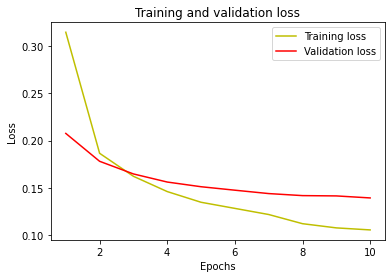

In [16]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

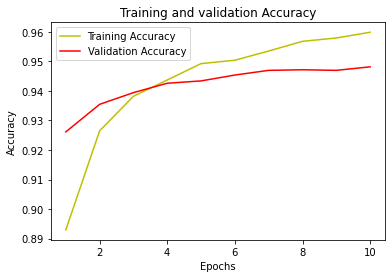

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model_efficientnet_b3.fit(
  train_original_ds,
  validation_data=val_original_ds,
  epochs=10
)

Epoch 1/10
630/630 [==============================] - 105s 166ms/step - loss: 0.0984 - accuracy: 0.9646 - val_loss: 0.1367 - val_accuracy: 0.9496
Epoch 2/10
630/630 [==============================] - 105s 166ms/step - loss: 0.0979 - accuracy: 0.9626 - val_loss: 0.1365 - val_accuracy: 0.9492
Epoch 3/10
630/630 [==============================] - 104s 166ms/step - loss: 0.0926 - accuracy: 0.9652 - val_loss: 0.1357 - val_accuracy: 0.9510
Epoch 4/10
630/630 [==============================] - 105s 166ms/step - loss: 0.0911 - accuracy: 0.9664 - val_loss: 0.1366 - val_accuracy: 0.9512
Epoch 5/10
630/630 [==============================] - 105s 166ms/step - loss: 0.0883 - accuracy: 0.9661 - val_loss: 0.1358 - val_accuracy: 0.9512
Epoch 6/10
630/630 [==============================] - 104s 166ms/step - loss: 0.0867 - accuracy: 0.9681 - val_loss: 0.1341 - val_accuracy: 0.9514
Epoch 7/10
630/630 [==============================] - 104s 166ms/step - loss: 0.0792 - accuracy: 0.9698 - val_loss: 0.1344 -

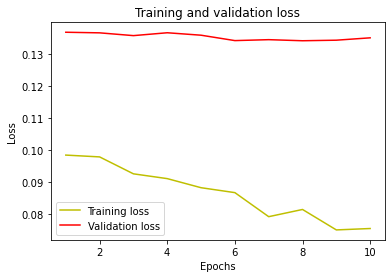

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

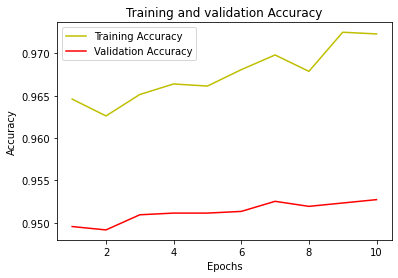

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model_efficientnet_b3.fit(
  train_original_ds,
  validation_data=val_original_ds,
  epochs=50
)

Epoch 1/50
630/630 [==============================] - 104s 165ms/step - loss: 0.0720 - accuracy: 0.9734 - val_loss: 0.1356 - val_accuracy: 0.9525
Epoch 2/50
630/630 [==============================] - 104s 166ms/step - loss: 0.0716 - accuracy: 0.9736 - val_loss: 0.1358 - val_accuracy: 0.9541
Epoch 3/50
630/630 [==============================] - 105s 166ms/step - loss: 0.0688 - accuracy: 0.9752 - val_loss: 0.1357 - val_accuracy: 0.9533
Epoch 4/50
630/630 [==============================] - 105s 166ms/step - loss: 0.0667 - accuracy: 0.9749 - val_loss: 0.1366 - val_accuracy: 0.9521
Epoch 5/50
630/630 [==============================] - 105s 167ms/step - loss: 0.0649 - accuracy: 0.9764 - val_loss: 0.1361 - val_accuracy: 0.9537
Epoch 6/50
630/630 [==============================] - 104s 166ms/step - loss: 0.0615 - accuracy: 0.9775 - val_loss: 0.1364 - val_accuracy: 0.9533
Epoch 7/50
630/630 [==============================] - 104s 166ms/step - loss: 0.0588 - accuracy: 0.9788 - val_loss: 0.1369 -

KeyboardInterrupt: 

## Test

In [18]:
# Now we get a test dataset.
test_dir = '../Data/test'
test_dir = pathlib.Path(test_dir)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

#test_ds = test_ds.map(lambda x, y: (preprocess_images(x), y))

Found 1889 files belonging to 2 classes.


In [19]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model_efficientnet_b3.evaluate(test_ds)
dict(zip(model_efficientnet_b3.metrics_names, result))

Evaluate
60/60 [==============================] - 8s 119ms/step - loss: 0.2717 - accuracy: 0.9021


{'loss': 0.271740198135376, 'accuracy': 0.9020645618438721}

In [33]:
scores = []
for x_val, y_val in test_ds:
    y_pred = model_efficientnet_b3.predict(x_val)
    normal = y_pred < 0.5
    y_pred[normal] = 0
    y_pred[~normal] = 1
    scores.append(accuracy_score(y_pred,y_val))

In [34]:
np.mean(np.array(scores))

0.9161458333333333

# VGG16

## Train

In [11]:
# create the base pre-trained model

base_model_vgg = tf.keras.applications.VGG16(weights='imagenet',
                                                     include_top=False, input_shape = input_size)

# add a global spatial average pooling layer
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(n_classes, activation='sigmoid')(x)

58900480/58889256 [==============================] - 6s 0us/step


In [12]:
# this is the model we will train
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions)

In [13]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model_vgg.layers):
   print(i, layer.name)


0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [16]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model_vgg.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_vgg.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model_vgg.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
630/630 [==============================] - 82s 100ms/step - loss: 0.2499 - accuracy: 0.9115 - val_loss: 0.2571 - val_accuracy: 0.9069
Epoch 2/10
630/630 [==============================] - 59s 94ms/step - loss: 0.1834 - accuracy: 0.9303 - val_loss: 0.1803 - val_accuracy: 0.9347
Epoch 3/10
630/630 [==============================] - 59s 94ms/step - loss: 0.1658 - accuracy: 0.9381 - val_loss: 0.1640 - val_accuracy: 0.9376
Epoch 4/10
630/630 [==============================] - 59s 94ms/step - loss: 0.1550 - accuracy: 0.9439 - val_loss: 0.1673 - val_accuracy: 0.9422
Epoch 5/10
630/630 [==============================] - 59s 94ms/step - loss: 0.1448 - accuracy: 0.9458 - val_loss: 0.2049 - val_accuracy: 0.9285
Epoch 6/10
630/630 [==============================] - 58s 92ms/step - loss: 0.1397 - accuracy: 0.9481 - val_loss: 0.1619 - val_accuracy: 0.9412
Epoch 7/10
630/630 [==============================] - 58s 91ms/step - loss: 0.1323 - accuracy: 0.9504 - val_loss: 0.1665 - val_accuracy

In [17]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_vgg.layers[:11]:
   layer.trainable = False
for layer in model_vgg.layers[11:]:
   layer.trainable = True

In [18]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model_vgg.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model_vgg.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
630/630 [==============================] - 84s 131ms/step - loss: 0.0934 - accuracy: 0.9664 - val_loss: 0.1482 - val_accuracy: 0.9498
Epoch 2/10
630/630 [==============================] - 83s 131ms/step - loss: 0.0562 - accuracy: 0.9797 - val_loss: 0.1387 - val_accuracy: 0.9539
Epoch 3/10
630/630 [==============================] - 83s 131ms/step - loss: 0.0372 - accuracy: 0.9876 - val_loss: 0.1381 - val_accuracy: 0.9541
Epoch 4/10
630/630 [==============================] - 83s 131ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.1731 - val_accuracy: 0.9527
Epoch 5/10
630/630 [==============================] - 83s 131ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.1421 - val_accuracy: 0.9597
Epoch 6/10
630/630 [==============================] - 83s 131ms/step - loss: 0.0096 - accuracy: 0.9979 - val_loss: 0.1934 - val_accuracy: 0.9446
Epoch 7/10
630/630 [==============================] - 83s 131ms/step - loss: 0.0059 - accuracy: 0.9988 - val_loss: 0.1841 - val_ac

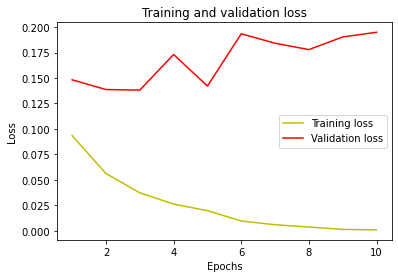

In [20]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

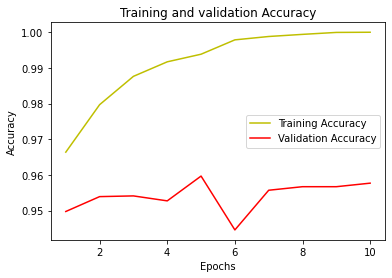

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Test

In [22]:
# Now we get a test dataset.
test_dir = '../Data/test'
test_dir = pathlib.Path(test_dir)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

test_ds = test_ds.map(lambda x, y: (preprocess_images(x,'vgg'), y))

Found 1889 files belonging to 2 classes.


In [23]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model_vgg.evaluate(test_ds)
dict(zip(model_vgg.metrics_names, result))

Evaluate
60/60 [==============================] - 5s 82ms/step - loss: 0.4090 - accuracy: 0.9227


{'loss': 0.408960223197937, 'accuracy': 0.9227104187011719}

# ResNet50

## Train

In [10]:
# create the base pre-trained model

base_model_resnet = tf.keras.applications.ResNet50(weights='imagenet',
                                                     include_top=False, input_shape = input_size)

# add a global spatial average pooling layer
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(n_classes, activation='sigmoid')(x)

94781440/94765736 [==============================] - 9s 0us/step


In [11]:
# this is the model we will train
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

In [12]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model_resnet.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_resnet.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model_resnet.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
630/630 [==============================] - 72s 88ms/step - loss: 0.2268 - accuracy: 0.9195 - val_loss: 0.1644 - val_accuracy: 0.9359
Epoch 2/10
630/630 [==============================] - 53s 85ms/step - loss: 0.1622 - accuracy: 0.9389 - val_loss: 0.1626 - val_accuracy: 0.9428
Epoch 3/10
630/630 [==============================] - 53s 84ms/step - loss: 0.1482 - accuracy: 0.9459 - val_loss: 0.1571 - val_accuracy: 0.9398
Epoch 4/10
630/630 [==============================] - 53s 85ms/step - loss: 0.1345 - accuracy: 0.9494 - val_loss: 0.1663 - val_accuracy: 0.9367
Epoch 5/10
630/630 [==============================] - 53s 84ms/step - loss: 0.1301 - accuracy: 0.9515 - val_loss: 0.1522 - val_accuracy: 0.9456
Epoch 6/10
630/630 [==============================] - 52s 83ms/step - loss: 0.1224 - accuracy: 0.9541 - val_loss: 0.1580 - val_accuracy: 0.9434
Epoch 7/10
630/630 [==============================] - 53s 84ms/step - loss: 0.1125 - accuracy: 0.9584 - val_loss: 0.1447 - val_accuracy:

In [15]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model_resnet.layers):
   print(i, layer.name)


0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [16]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_resnet.layers[:143]:
   layer.trainable = False
for layer in model_resnet.layers[143:]:
   layer.trainable = True

In [17]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate

model_resnet.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [18]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
history = model_resnet.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
630/630 [==============================] - 68s 105ms/step - loss: 0.1616 - accuracy: 0.9420 - val_loss: 0.1505 - val_accuracy: 0.9476
Epoch 2/10
630/630 [==============================] - 66s 104ms/step - loss: 0.0716 - accuracy: 0.9771 - val_loss: 0.1525 - val_accuracy: 0.9484
Epoch 3/10
630/630 [==============================] - 64s 102ms/step - loss: 0.0438 - accuracy: 0.9875 - val_loss: 0.1570 - val_accuracy: 0.9482
Epoch 4/10
630/630 [==============================] - 64s 102ms/step - loss: 0.0266 - accuracy: 0.9945 - val_loss: 0.1636 - val_accuracy: 0.9496
Epoch 5/10
630/630 [==============================] - 64s 102ms/step - loss: 0.0163 - accuracy: 0.9984 - val_loss: 0.1684 - val_accuracy: 0.9517
Epoch 6/10
630/630 [==============================] - 64s 102ms/step - loss: 0.0107 - accuracy: 0.9992 - val_loss: 0.1752 - val_accuracy: 0.9519
Epoch 7/10
630/630 [==============================] - 64s 102ms/step - loss: 0.0075 - accuracy: 0.9997 - val_loss: 0.1799 - val_ac

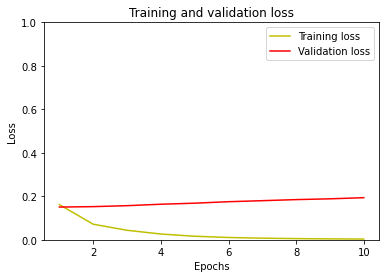

In [22]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

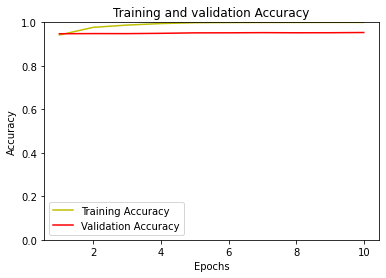

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.ylim(0, 1)
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Test

In [23]:
# Now we get a test dataset.
test_dir = '../Data/test'
test_dir = pathlib.Path(test_dir)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

test_ds = test_ds.map(lambda x, y: (preprocess_images(x, 'res'), y))

Found 1889 files belonging to 2 classes.


In [24]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model_resnet.evaluate(test_ds)
dict(zip(model_resnet.metrics_names, result))

Evaluate
60/60 [==============================] - 6s 86ms/step - loss: 0.4349 - accuracy: 0.8931


{'loss': 0.43494048714637756, 'accuracy': 0.8930650949478149}